## Some code from last time

In [1]:
# Now it's time to use this dictionary!
Daltons = { 
    'A':  71, 'C': 103, 'D': 115, 'E': 129,
    'F': 147, 'G':  57, 'H': 137, 'I': 113,
    'K': 128, 'L': 113, 'M': 131, 'N': 114,
    'P':  97, 'Q': 128, 'R': 156, 'S':  87,
    'T': 101, 'V':  99, 'W': 186, 'Y': 163 
}

def TheoreticalSpectrum(peptide):
    # Generate every possible fragment of a peptide
    spectrum = set()
    for fragLength in range(1,len(peptide)+1):
        for start in range(0,len(peptide)-fragLength+1):
            seq = peptide[start:start+fragLength]
            spectrum.add(sum([Daltons[res] for res in seq]))
    return sorted(spectrum)

insulin = 'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTR' \
        + 'REAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'
insulinSpectrum = TheoreticalSpectrum(insulin)
print(len(insulinSpectrum))

4123


## Reminder where we left off

In [2]:
def UltimatePossiblePeptide(spectrum, prefix=''):
    global peptideList
    if (len(prefix) == 0):
        peptideList = []
    current = sum([Daltons[res] for res in prefix])
    target = max(spectrum)
    if (current == target):
        peptideList.append(prefix)
    elif (current < target):
        for residue in Daltons.keys():
            extend = prefix + residue
            # test every new suffix created by adding this new residue
            # Note: this includes the residue itself as the length 1 suffix
            suffix = [extend[i:] for i in range(len(extend))]
            for fragment in suffix:
                if (sum([Daltons[res] for res in fragment]) not in spectrum):
                    break
            else:
                UltimatePossiblePeptide(spectrum, extend)

test = TheoreticalSpectrum(insulin[0:40])
%time UltimatePossiblePeptide(test)
print(len(test), len(peptideList))

CPU times: user 2min 40s, sys: 0 ns, total: 2min 40s
Wall time: 2min 40s
634 8192


In [3]:
insulin[0:40] in peptideList

True

## An aside: Faking an Experimental Spectrum

In [4]:
# generate a synthetic experimental spectrum with 10% Error
import itertools
import random
random.seed(1961)

TyrocidineB1 = "VKLFPWFNQY"
spectrum = TheoreticalSpectrum(TyrocidineB1)

# Pick around ~10% at random to remove
missingMass = random.sample(spectrum[:-1], 6)  # keep largest mass
print("Missing Masses = ", missingMass)

# Add back another ~10% of false, but actual, peptide masses
falseMass = []
for i in range(5):
    fragment = ''.join(random.sample(Daltons.keys(), random.randint(2,len(TyrocidineB1)-2)))
    weight = sum([Daltons[residue] for residue in fragment])
    falseMass.append(weight)
print("False Masses = ", falseMass)

experimentalSpectrum = sorted(set([mass for mass in spectrum if mass not in missingMass] + falseMass))

Missing Masses =  [917, 114, 244, 405, 241, 99]
False Masses =  [211, 652, 691, 359, 354]


In [5]:
print(experimentalSpectrum)

[97, 113, 128, 147, 163, 186, 211, 227, 242, 260, 261, 283, 291, 333, 340, 354, 357, 359, 388, 389, 430, 447, 485, 487, 543, 544, 552, 575, 577, 584, 652, 671, 672, 690, 691, 738, 770, 804, 818, 819, 835, 932, 982, 1031, 1060, 1095, 1159, 1223, 1322]


## An Implementation

In [6]:
def LeaderboardFindPeptide(noisySpectrum, cutThreshold=0.05):
    # Golf Tournament Heuristic
    spectrum = set(noisySpectrum)
    target = max(noisySpectrum)
    players = [''.join(peptide) for peptide in itertools.product(Daltons.keys(), repeat=2)]
    round = 1
    currentLeader = [0.0, '']
    while True:
        print("%8d Players in round %d [%5.4f]" % (len(players), round, currentLeader[0]))
        leaderboard = []
        for prefix in players:
            testSpectrum = set(TheoreticalSpectrum(prefix))
            totalWeight = max(testSpectrum)
            score = len(spectrum & testSpectrum)/float(len(spectrum | testSpectrum))
            if (score > currentLeader[0]):
                currentLeader = [score, prefix]
            elif (score == currentLeader[0]):
                currentLeader += [prefix]
            if (totalWeight < target):
                leaderboard.append((score, prefix))
        remaining = len(leaderboard)
        if (remaining == 0):
            print("Done, no sequences can be extended")
            break
        leaderboard.sort(reverse=True)
        # Prune the larger of the top 5% or the top 5 players
        cut = leaderboard[max(min(5,remaining-1),int(remaining*cutThreshold))][0]
        players = [p+r for s, p in leaderboard if s >= cut for r in Daltons.keys()]
        round += 1
    return currentLeader

spectrum = TheoreticalSpectrum(TyrocidineB1)
experimentalSpectrum = [mass for mass in spectrum if mass not in missingMass] + falseMass
%time winners = LeaderboardFindPeptide(experimentalSpectrum)
print(winners)
print(len(winners) - 1, "Candidate residues with", winners[0], 'matches')
print(TyrocidineB1, TyrocidineB1 in winners)

     400 Players in round 1 [0.0000]
    1440 Players in round 2 [0.0612]
    4960 Players in round 3 [0.1224]
    6400 Players in round 4 [0.1800]
    9380 Players in round 5 [0.2800]
   10000 Players in round 6 [0.3725]
   11820 Players in round 7 [0.4706]
   12800 Players in round 8 [0.5962]
   12880 Players in round 9 [0.6981]
    7520 Players in round 10 [0.8182]
     640 Players in round 11 [0.8182]
Done, no sequences can be extended
CPU times: user 3.44 s, sys: 22.3 ms, total: 3.47 s
Wall time: 3.4 s
[0.8181818181818182, 'YQNFWPFLQV', 'YQNFWPFLKV', 'YQNFWPFIQV', 'YQNFWPFIKV', 'YKNFWPFLQV', 'YKNFWPFLKV', 'YKNFWPFIQV', 'YKNFWPFIKV', 'VQLFPWFNQY', 'VQLFPWFNKY', 'VQIFPWFNQY', 'VQIFPWFNKY', 'VKLFPWFNQY', 'VKLFPWFNKY', 'VKIFPWFNQY', 'VKIFPWFNKY']
16 Candidate residues with 0.8181818181818182 matches
VKLFPWFNQY True


## Let’s try a Nosier Spectrum

In [7]:
# generate a synthetic experimental spectrum with 60% Error
import random
random.seed(1961)

TyrocidineB1 = "VKLFPWFNQY"
print(TyrocidineB1)
spectrum = TheoreticalSpectrum(TyrocidineB1)
print(len(spectrum), spectrum)

# Pick around ~40% at random to remove
missingMass = random.sample(spectrum[:-1], 20)
print("\nMissing Masses = %s\n" % missingMass)

# Add back another ~10% of false, but actual, peptide masses
falseMass = []
for i in range(5):
    fragment = ''.join(random.sample(Daltons.keys(), random.randint(2,len(TyrocidineB1)-2)))
    weight = sum([Daltons[residue] for residue in fragment])
    falseMass.append(weight)
print("False Masses = ", falseMass)

experimentalSpectrum = sorted(set([mass for mass in spectrum if mass not in missingMass] + falseMass))

print(len(experimentalSpectrum), experimentalSpectrum)

VKLFPWFNQY
51 [97, 99, 113, 114, 128, 147, 163, 186, 227, 241, 242, 244, 260, 261, 283, 291, 333, 340, 357, 388, 389, 405, 430, 447, 485, 487, 543, 544, 552, 575, 577, 584, 671, 672, 690, 691, 738, 770, 804, 818, 819, 835, 917, 932, 982, 1031, 1060, 1095, 1159, 1223, 1322]

Missing Masses = [917, 114, 244, 405, 241, 99, 982, 487, 430, 584, 804, 552, 147, 227, 97, 672, 770, 1031, 485, 818]

False Masses =  [601, 354, 242, 200, 380]
35 [113, 128, 163, 186, 200, 242, 260, 261, 283, 291, 333, 340, 354, 357, 380, 388, 389, 447, 543, 544, 575, 577, 601, 671, 690, 691, 738, 819, 835, 932, 1060, 1095, 1159, 1223, 1322]


## Find peptides via the leaderboard approach

In [8]:
spectrum = TheoreticalSpectrum(TyrocidineB1)
experimentalSpectrum = [mass for mass in spectrum if mass not in missingMass] + falseMass
%time winners = LeaderboardFindPeptide(experimentalSpectrum)
print(winners)
print(len(winners) - 1, "Candidate residues with", winners[0], 'matches')
print(TyrocidineB1, TyrocidineB1 in winners)

     400 Players in round 1 [0.0000]
     960 Players in round 2 [0.0857]
    1300 Players in round 3 [0.1389]
    1740 Players in round 4 [0.2162]
    4280 Players in round 5 [0.2895]
    5600 Players in round 6 [0.3333]
    5800 Players in round 7 [0.4524]
    5960 Players in round 8 [0.5333]
    6120 Players in round 9 [0.5833]
    2480 Players in round 10 [0.5833]
     240 Players in round 11 [0.5833]
Done, no sequences can be extended
CPU times: user 1.5 s, sys: 11.7 ms, total: 1.51 s
Wall time: 1.48 s
[0.5833333333333334, 'YQNFWPFLK', 'YQNFWPFLQ', 'YQNFWPFIK', 'YQNFWPFIQ', 'YKNFWPFLK', 'YKNFWPFLQ', 'YKNFWPFIK', 'YKNFWPFIQ']
8 Candidate residues with 0.5833333333333334 matches
VKLFPWFNQY False


## Spectral Convolution

* Spectral Convolution gives us an approach for recovering some missing masses
* Given a noisy experimental spectrum
  1. Compute its spectral convolution
  2. Add frequent masses above some threshold to the spectrum
  3. Infer the peptide sequence

In [9]:
def SpectralConvolution(spectrum):
    delta = {}
    for i in range(len(spectrum)-1):
        for j in range(i+1,len(spectrum)):
            diff = abs(spectrum[j] - spectrum[i])
            delta[diff] = delta.get(diff, 0) + 1
    return delta

## Spiking with Spectral Convolution

In [10]:
spectrum = TheoreticalSpectrum(TyrocidineB1)
print(sorted(missingMass), len(missingMass))
experimentalSpectrum = sorted(set([mass for mass in spectrum if mass not in missingMass] + falseMass))
specConv = SpectralConvolution(sorted(experimentalSpectrum))
N = 0
for delta, count in sorted(specConv.items()):
    if (count >= 2) and (delta not in experimentalSpectrum) and (delta > min(Daltons.values())):
        print("%3d appears %1d times%s\t" % (delta, count,  '*' if delta in missingMass else ' '), end='')
        experimentalSpectrum.append(delta)
        N += 1
        if (N % 4 == 0):
            print()
print()

[97, 99, 114, 147, 227, 241, 244, 405, 430, 485, 487, 552, 584, 672, 770, 804, 818, 917, 982, 1031] 20
 58 appears 3 times 	 64 appears 2 times 	 67 appears 2 times 	 72 appears 2 times 	
 73 appears 2 times 	 74 appears 2 times 	 79 appears 2 times 	 89 appears 2 times 	
 90 appears 2 times 	 91 appears 2 times 	 93 appears 2 times 	 94 appears 2 times 	
 96 appears 3 times 	 97 appears 8 times*	 98 appears 3 times 	 99 appears 2 times*	
105 appears 2 times 	114 appears 3 times*	115 appears 2 times 	120 appears 2 times 	
127 appears 2 times 	129 appears 3 times 	133 appears 2 times 	146 appears 2 times 	
147 appears 5 times*	148 appears 3 times 	154 appears 4 times 	155 appears 3 times 	
156 appears 2 times 	164 appears 3 times 	170 appears 2 times 	187 appears 3 times 	
188 appears 2 times 	189 appears 3 times 	194 appears 4 times 	195 appears 2 times 	
203 appears 2 times 	205 appears 2 times 	212 appears 2 times 	218 appears 2 times 	
220 appears 2 times 	221 appears 2 times 	225 a

## Now we try again

In [11]:
%time winners = LeaderboardFindPeptide(experimentalSpectrum)
print(winners)
print(len(winners) - 1, "Candidate residues with", winners[0], 'matches')
print(TyrocidineB1, TyrocidineB1 in winners)

     400 Players in round 1 [0.0000]
    1600 Players in round 2 [0.0234]
    3600 Players in round 3 [0.0469]
    8220 Players in round 4 [0.0781]
    8460 Players in round 5 [0.1172]
   14260 Players in round 6 [0.1641]
   18880 Players in round 7 [0.2031]
   19140 Players in round 8 [0.2656]
   19240 Players in round 9 [0.3101]
    8560 Players in round 10 [0.3561]
    2160 Players in round 11 [0.3561]
     160 Players in round 12 [0.3561]
Done, no sequences can be extended
CPU times: user 4.88 s, sys: 17.5 ms, total: 4.9 s
Wall time: 4.85 s
[0.3560606060606061, 'YQNFWPFLQV', 'YQNFWPFLKV', 'YQNFWPFIQV', 'YQNFWPFIKV', 'YKNFWPFLQV', 'YKNFWPFLKV', 'YKNFWPFIQV', 'YKNFWPFIKV', 'VQLFPWFNQY', 'VQLFPWFNKY', 'VQIFPWFNQY', 'VQIFPWFNKY', 'VKLFPWFNQY', 'VKLFPWFNKY', 'VKIFPWFNQY', 'VKIFPWFNKY']
16 Candidate residues with 0.3560606060606061 matches
VKLFPWFNQY True


## A More *Realistic* Example

In [12]:
Insulin = "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
spectrum = TheoreticalSpectrum(Insulin)
print(len(spectrum))
missingMass = random.sample(spectrum[:-1], 50)
experimentalSpectrum = sorted([mass for mass in spectrum if mass not in missingMass])
print(len(experimentalSpectrum))

del Daltons['I']
del Daltons['K']

%time winners = LeaderboardFindPeptide(experimentalSpectrum, cutThreshold=0.01)
print(winners)
print(len(winners) - 1, "Candidate residues with", winners[0], 'matches')
print(Insulin, Insulin in winners)

Daltons['I'] = Daltons['L']
Daltons['K'] = Daltons['Q']

3407
3357
     324 Players in round 1 [0.0000]
    3492 Players in round 2 [0.0009]
   21528 Players in round 3 [0.0018]
   88344 Players in round 4 [0.0030]
  222696 Players in round 5 [0.0045]
  306576 Players in round 6 [0.0063]
  227664 Players in round 7 [0.0083]
   85176 Players in round 8 [0.0107]
   17262 Players in round 9 [0.0134]
    7164 Players in round 10 [0.0164]
    2412 Players in round 11 [0.0194]
     702 Players in round 12 [0.0229]
     180 Players in round 13 [0.0265]
     108 Players in round 14 [0.0301]
     108 Players in round 15 [0.0336]
     126 Players in round 16 [0.0371]
     108 Players in round 17 [0.0403]
     126 Players in round 18 [0.0439]
     108 Players in round 19 [0.0473]
     108 Players in round 20 [0.0514]
     108 Players in round 21 [0.0556]
     108 Players in round 22 [0.0602]
     108 Players in round 23 [0.0655]
     108 Players in round 24 [0.0701]
     108 Players in round 25 [0.0741]
     108 Players in round 26 [0.0783]
     108 Pl

## SPC Diminishes Quickly

In [13]:
print(TheoreticalSpectrum('PRTEIN'))
print(TheoreticalSpectrum('PRTEYN'))
print(TheoreticalSpectrum('PWTEYN'))

print(set(TheoreticalSpectrum('PRTEIN')) & set(TheoreticalSpectrum('PRTEYN')))
print(set(TheoreticalSpectrum('PRTEIN')) & set(TheoreticalSpectrum('PWTEYN')))

[97, 101, 113, 114, 129, 156, 227, 230, 242, 253, 257, 343, 354, 356, 386, 457, 483, 499, 596, 613, 710]
[97, 101, 114, 129, 156, 163, 230, 253, 257, 277, 292, 354, 386, 393, 406, 483, 507, 549, 646, 663, 760]
[97, 101, 114, 129, 163, 186, 230, 277, 283, 287, 292, 384, 393, 406, 416, 507, 513, 579, 676, 693, 790]
{129, 386, 257, 97, 354, 483, 101, 230, 114, 156, 253}
{129, 97, 101, 230, 114}


In [14]:
import numpy
import matplotlib
import matplotlib.pyplot as plot
%matplotlib inline
import random
random.seed(1961)

def SpectralConvolution(peptide1, peptide2):
    spectrum1 = TheoreticalSpectrum(peptide1)
    spectrum2 = TheoreticalSpectrum(peptide2)
    N = len(spectrum1)
    M = len(spectrum2)
    repeat = {}

    matplotlib.rc('ytick', labelsize=6)
    matplotlib.rc('xtick', labelsize=6)
    fig = plot.figure(figsize=(6,6))
    ax = plot.gca()
    plot.axis([0, N+1, 0, M+1])
    for i in range(len(spectrum1)):
        for j in range(len(spectrum2)):
            delta = spectrum2[j]-spectrum1[i]
            if (delta == 0):
                circle = plot.Circle((i+1, j+1), 0.4, color='r')
                ax.add_artist(circle)
            else:
                repeat[delta] = repeat.get(delta,[]) + [(i+1,j+1)]
            plot.text(i+1,j+1,str(delta), fontsize=6, ha="center", va="center")

    for delta, coordList in repeat.items():
        R = len(coordList)
        if (R < 2):
            continue
        if (R == 2):
            cval = 'k'
            for x, y in coordList:
                box = plot.Rectangle((x-0.4,y-0.4), 0.8, 0.8, color=cval, fill=False)
                ax.add_artist(box)
        else:
            cval = '#%02x%02x%02x' % (random.randint(64,255),random.randint(64,255),random.randint(64,255))
            for x, y in coordList:
                box = plot.Rectangle((x-0.4,y-0.4), 0.8, 0.8, color=cval)
                ax.add_artist(box)

    plot.xticks(range(1,N+1), [str(peak) for peak in spectrum1])
    plot.yticks(range(1,M+1), [str(peak) for peak in spectrum2])
    plot.xlabel(peptide1)
    plot.ylabel(peptide2)

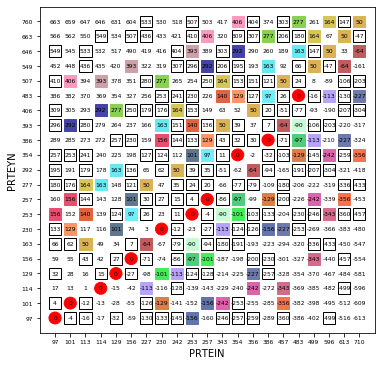

In [15]:
SpectralConvolution('PRTEIN', 'PRTEYN')

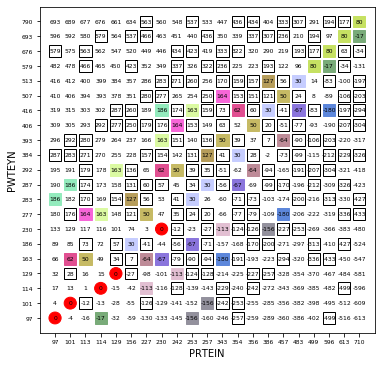

In [16]:
SpectralConvolution('PRTEIN', 'PWTEYN')